In [1]:
import os
import json
import numpy as np
import torch
import pathlib
import matplotlib.pyplot as plt

import utils
from utils.func_yarotsky import get_func
from utils.plotting import plot_function_2d
from utils.plotting import plot_model_2d
from utils.HeightNet import MLP
from utils.common import NN
from utils.nest1 import NestNet
from utils.nest2 import NestNet2
from utils.parse_log import parse_tensorboard_log

In [2]:
cwd = os.getcwd()
log_path = cwd + '/logs/retrain/'

In [3]:
def get_stats(path_):
    with open(path_, "r") as fp:
        retrain_dict = json.load(fp)
    test_errors = np.array([run['test_error'] for run in retrain_dict.values()])
    training_times = np.array([run['training_time'] for run in retrain_dict.values()])
    return {'mean_mse': test_errors.mean(),
           'min_mse': test_errors.min(),
           'max_mse': test_errors.max(),
           'training_time': training_times.mean(),
           'argmin': test_errors.argmin()}

def get_training_dict(log_path):
    training_dict = {}
    training_dict['height_1'] = get_stats(log_path + "retrain_1.json")
    training_dict['height_2'] = get_stats(log_path + "retrain_2.json")
    training_dict['height_3'] = get_stats(log_path + "retrain_3.json")
    return training_dict

def get_model(height, cwd):
    path_ = cwd + '/logs/ensemble/best_config_' + str(height) + '.json'
    with open(path_,"r") as fp:
        model_hyperparams = json.load(fp)
    model_hyperparams['seed'] = 0
    
    if height == 3:
        network = NestNet2(**model_hyperparams)
    elif height == 2:
        network = NestNet(**model_hyperparams)
    else:
        network = MLP(**model_hyperparams)
        
    model = NN(network, learning_rate=0)
    ckp_root = cwd + '/logs/retrain/' + model_hyperparams['name'] + '/version_' + str(training_dict['height_' + str(height)]['argmin'])
    ckp_path = str(list(pathlib.Path(ckp_root).rglob('*.ckpt'))[0])
    ckp = torch.load(ckp_path)
    model.load_state_dict(ckp['state_dict'])
    return model

def parse_log(height, cwd):
    path_ = cwd + '/logs/ensemble/best_config_' + str(height) + '.json'
    with open(path_,"r") as fp:
        model_hyperparams = json.load(fp)
    log_root = cwd + '/logs/retrain/' + model_hyperparams['name'] + '/version_' + str(training_dict['height_' + str(height)]['argmin'])
    log_path = str(list(pathlib.Path(log_root).rglob('*.local'))[0])
    return parse_tensorboard_log(log_path)

In [4]:
training_dict = get_training_dict(log_path)

names = list(training_dict.keys())
print(f"{'model' : <15}{'training time' : >15}{'mean mse' : >20}{'min mse' : >20}{'max mse' : >20}")
print(f'{"="*90}')
for i, key in enumerate(training_dict.keys()):
    print(f"{key: <15}{training_dict[key]['training_time']:>15.2f}{training_dict[key]['mean_mse']:>20.4e}{training_dict[key]['min_mse']:>20.4e}{training_dict[key]['max_mse']:>20.4e}")


model            training time            mean mse             min mse             max mse
height_1                203.78          2.5977e-04          4.4433e-05          3.5039e-04
height_2                257.34          3.7418e-04          3.0023e-06          1.4162e-03
height_3                405.69          1.0637e-03          6.4101e-06          1.4162e-03


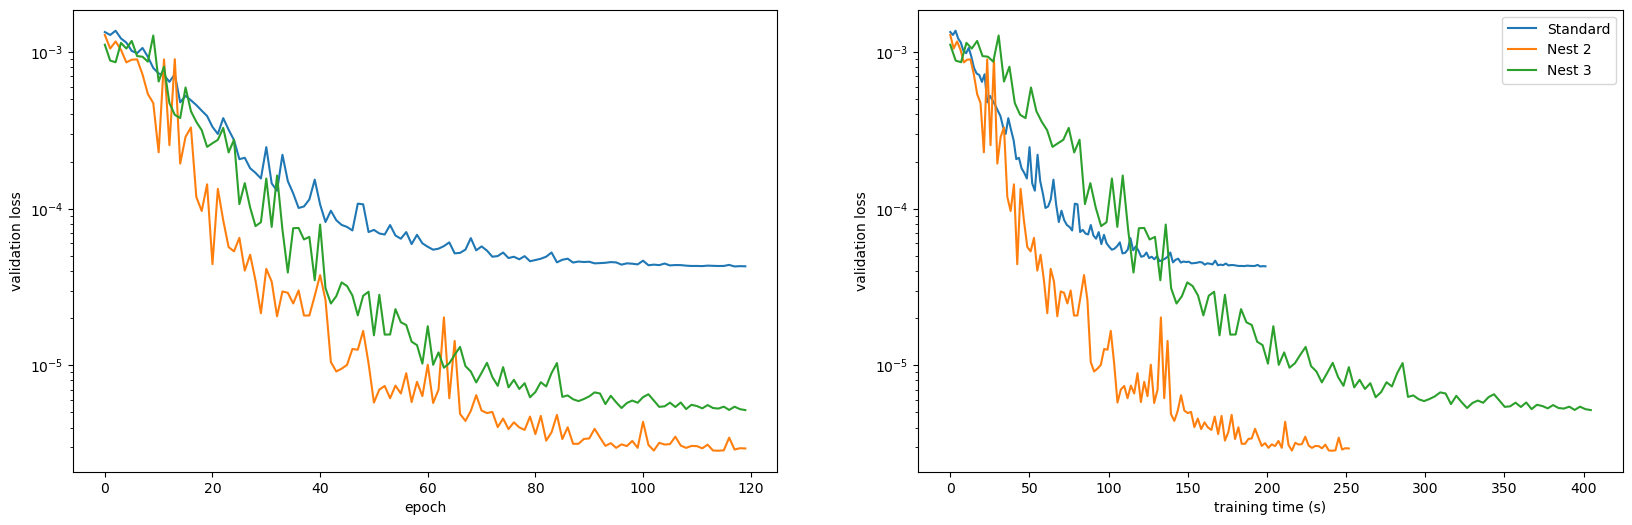

In [5]:
df_height1 = parse_log(height=1, cwd=cwd)
df_height2 = parse_log(height=2, cwd=cwd)
df_height3 = parse_log(height=3, cwd=cwd)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].semilogy(df_height1['val_loss'])
axs[0].semilogy(df_height2['val_loss'])
axs[0].semilogy(df_height3['val_loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('validation loss')

axs[1].semilogy(df_height1['wall_time'], df_height1['val_loss'], label='Standard')
axs[1].semilogy(df_height2['wall_time'], df_height2['val_loss'], label='Nest 2')
axs[1].semilogy(df_height3['wall_time'], df_height3['val_loss'], label='Nest 3')
axs[1].set_xlabel('training time (s)')
axs[1].set_ylabel('validation loss')
axs[1].legend()

plt.savefig(cwd + '/plot.png')

# Visualize target function and learned functions

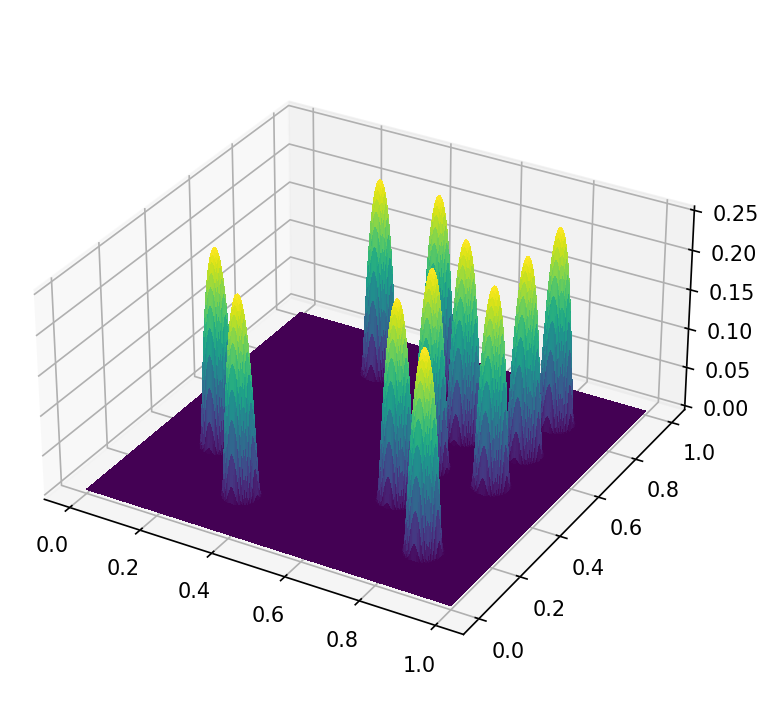

In [6]:
func = get_func(5)
plot_function_2d(func, path = cwd + '/function.png')

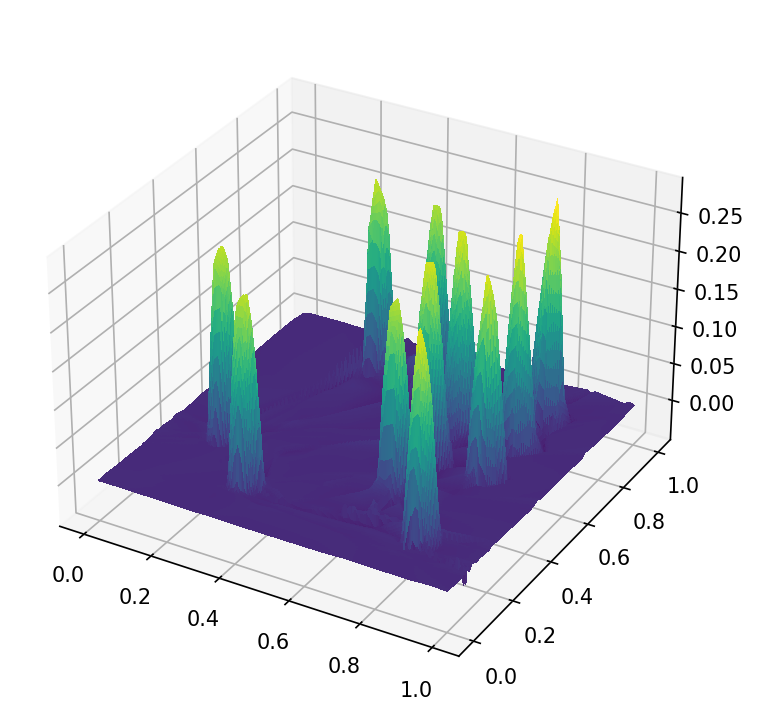

In [7]:
model_1 = get_model(height=1, cwd=cwd)
plot_model_2d(model_1, path = cwd + '/mlp.png')

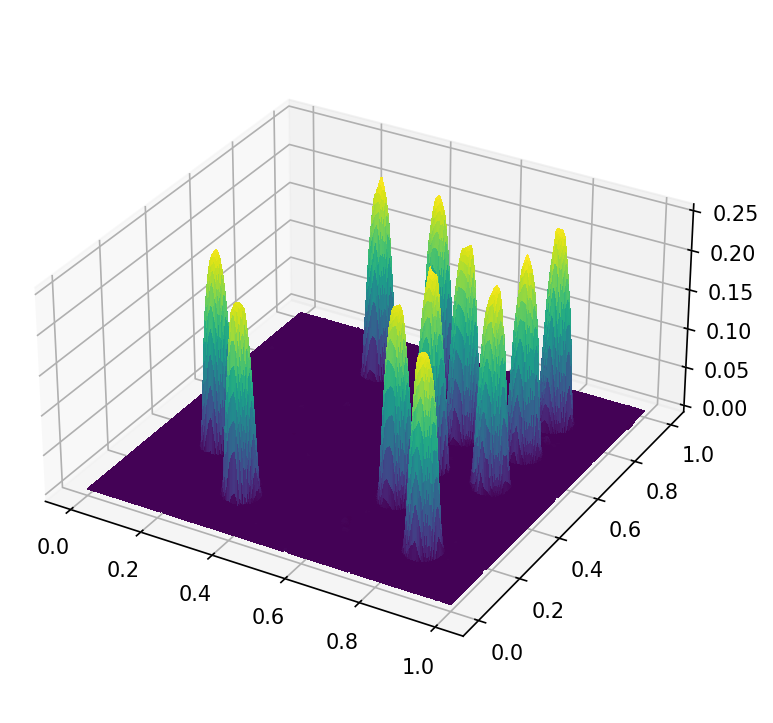

In [8]:
model_2 = get_model(height=2, cwd=cwd)
plot_model_2d(model_2, path = cwd + '/nest1.png')

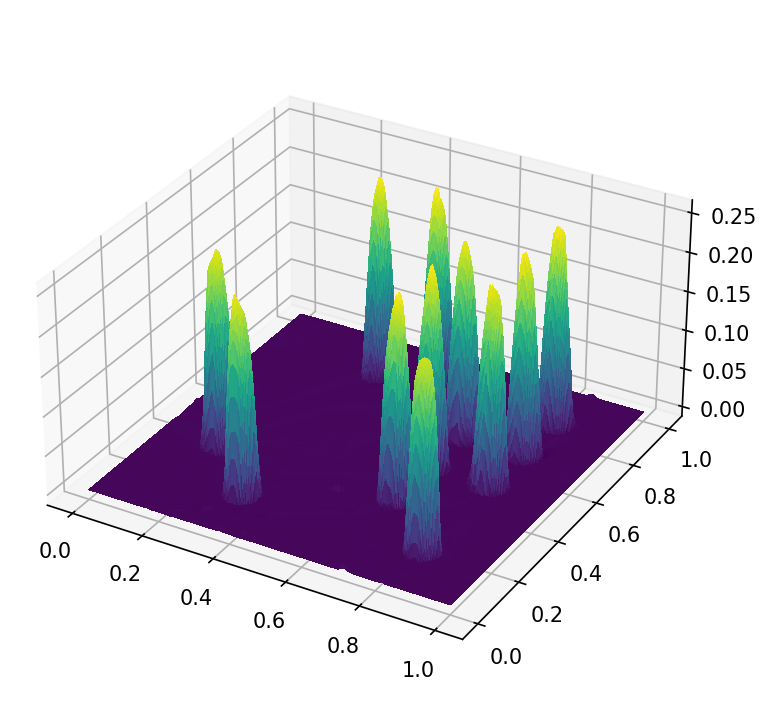

In [9]:
model_3 = get_model(height=3, cwd=cwd)
plot_model_2d(model_3, path = cwd + '/nest2.png')

In [10]:
%reload_ext tensorboard
%tensorboard --logdir="$log_path"